# Nonogram

This project aims to implement and resolve the Nonogram game, a japanese crossword like game.

For this project, I will use and refer to this website: <https://www.nonograms.org>.

* The rules of the game are available [here](https://www.nonograms.org/instructions).
* The strategies to solve the game are [here](https://www.nonograms.org/methods).

Steps :
* [ ] Implement the basic vesion of the game (not colored)
    * [ ] Put it inside a python file (instead of a notebook)
    * [ ] Write unit tests with pytest 
* [ ] Format the code with black, isort and pydocstyle, then lint with pylint
* [ ] Code the solver
    * [ ] Write a function that generate all the options for a given row
    * [ ] Remove absurd options
    * [ ] Fill cells with basic strategies (superposition)
* [ ] Scrappe puzzles from the site
    * [ ] Write a nice class for the game and the solver
    * [ ] Write unit tests to verify the solver
* [ ] Create a graphic interphace with pygame
* [ ] (Later) Solve the game with colors

## Implementing the game

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

In [2]:
def generate_spaces(p, nc):
    options = []
    
    if nc == 0:
        return [[p]]
    else:
        for x in range(p+1):
            nc_p = nc - 1
            p_p = p - x
            options_p = generate_spaces(p_p, nc_p)
            for o in options_p:
                l = [x]
                l.extend(o)
                options.append(l)
        return options

In [3]:
def generate_options(n, coefs):
    nc = len(coefs)
    t = sum(coefs) + nc - 1
    p = n-t
    
    if t > n:
        raise ValueError("To many coefficients")
    
    options = []
    spaces = generate_spaces(p, nc)
    
    for s in spaces:
        l = [0 for i in range(n)]
        res = 0
        for i in range(len(s)-1):
            res += s[i]
            for j in range(coefs[i]):
                l[res+j] = 1
            res += coefs[i] + 1
        options.append(l)
    return options

In [4]:
class Game:
    def __init__(self, board, row_coefs, col_coefs):
        """TODO: Add assertions on board/coefs"""
        self.board = board
        self.n, self.m = board.shape
        self.row_coefs = row_coefs
        self.col_coefs = col_coefs

In [5]:
class Solver:
    def __init__(self, game):
        self.board = game.board.copy()
        self.previous_board = None
        self.row_length = self.n = game.n
        self.col_length = self.m = game.m
        self.row_coefs = game.row_coefs
        self.col_coefs = game.col_coefs
        self.row_options = self.init_options("row")
        self.col_options = self.init_options("col")
    
    def init_options(self, axis):
        if axis == "row" or axis =="r":
            size, list_coefs = self.row_length, self.row_coefs
        elif axis == "col" or axis =="c":
            size, list_coefs = self.col_length, self.col_coefs
        else:
            raise ValueError("Parameter must be in 'row', 'r' for rows or 'col', 'c' for columns")
        
        options = []
        for i in range(len(list_coefs)):
            options.append(generate_options(size, list_coefs[i]))
        
        return options
    
    def is_finished(self):
        return (self.board != -1).all()
    
    def check_absurd_options(self):
        # Check rows
        for r in range(self.n):
            row = self.board[r, :]
            for x, opt in enumerate(self.row_options[r]):
                if np.any([(row[i]!=-1 and opt[i]!=row[i]) for i in range(len(row))]):
                    self.row_options[r].pop(x)
        
        # Check cols
        for c in range(self.m):
            col = self.board[:, c]
            for x, opt in enumerate(self.col_options[c]):
                if np.any([(col[i]!=-1 and opt[i]!=col[i]) for i in range(len(col))]):
                    self.col_options[c].pop(x)
                    
        return None
    
    
    def check_superposition(self):
        # Check rows
        for r in range(self.n):
            for i in range(self.m):
                if self.board[r, i] == -1 and (np.array(self.row_options[r])[:, i] == self.row_options[r][0][i]).all():
                    self.board[r, i] = self.row_options[r][0][i]
        
        # Check cols
        for c in range(self.m):
            for i in range(self.n):
                if self.board[i, c] == -1 and (np.array(self.col_options[c])[:, i] == self.col_options[c][0][i]).all():
                    self.board[i, c] = self.col_options[c][0][i]
                    
        return None
    
    def solve(self, check_previous=True):
        while not self.is_finished():
            if check_previous:
                self.previous_board = self.board.copy()
            
            self.check_absurd_options()
            self.check_superposition()
            
            if check_previous and (self.previous_board == self.board).all():
                raise Error("No Progress")
            
        if self.is_finished():
            print("Game is solved!\n")
            print(self.board)

In [15]:
n = 10
b = -np.ones((n, n))

b = np.array([
    [-1, -1, -1,  0, -1, -1,  0, -1,  0,  0],
    [-1, -1, -1, -1, -1, -1, -1,  0, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1,  0],
    [ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0, -1, -1, -1,  0, -1, -1, -1,  0],
    [-1,  0, -1, -1, -1,  0, -1, -1,  0, -1],
    [ 0,  0, -1, -1, -1,  0,  0, -1, -1,  0],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
])

rows = [
    [2],
    [4],
    [6],
    [8],
    [10],
    [3, 1],
    [3, 1],
    [3, 1],
    [10],
    [10],
]

cols = [
    [1, 2],
    [2, 2],
    [8],
    [9],
    [10],
    [5, 2],
    [4, 2],
    [8],
    [2, 2],
    [1, 2],
]

In [16]:
game = Game(board=b, row_coefs=rows, col_coefs=cols)

In [17]:
solver = Solver(game)

In [18]:
solver.solve()

Game is solved!

[[0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 0 0 1 0 0]
 [0 0 1 1 1 0 0 1 0 0]
 [0 0 1 1 1 0 0 1 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


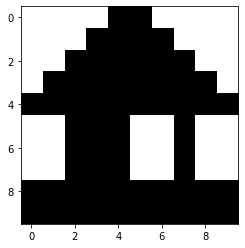

In [20]:
plt.imshow(solver.board, cmap=plt.cm.binary);